## Chapter 3
# Transfer learning from MobileNet trained for Imagenet dataset to Cifar10 dataset

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

print (tf.__version__)
print (keras.__version__)

1.12.0
2.1.6-tf


In [2]:

# This will download a new version of MobileNet as needed
from keras.applications.mobilenet import MobileNet, decode_predictions

mnet_tfr = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

Using TensorFlow backend.


In [3]:
for layer in mnet_tfr.layers:
    mnet_tfr.trainable = False

print (len(mnet_tfr.layers))

87


In [4]:
mnet_tfr.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [5]:
from keras.layers import Input, Lambda
from keras import backend as K

# input placeholder for cifar10 32x32x3 images
cifar10_input = Input(shape=(32,32,3))

# resize input (using Keras Lamba layer), attach to input
resized_inp = Lambda(lambda image: K.tf.image.resize_images(image, (224, 224)))(cifar10_input)

# feed resized images to MobileNet model
inp = mnet_tfr(resized_inp)

In [6]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
avg_pool = GlobalAveragePooling2D()(mnet_tfr.get_output_at(-1))
new_1 = Dropout(rate=0.75)(avg_pool)
new_2 = Dense(1024, activation='relu')(new_1)
estimation = Dense(10, activation='softmax')(new_2)

In [7]:
print (len(mnet_tfr.layers))
mnet_tfr.summary()

87
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_______

In [8]:
# Imports the Model API
from keras.models import Model

# Creates the model
model = Model(inputs=cifar10_input, outputs=estimation)

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Check the summary of this new model to confirm the architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10250     
Total para

In [9]:
import matplotlib.pyplot as plt
def dataVisualInspection(y_valid, y_test, y_train, n_classes):
    # Histogram of labels in training, test and validation data
    plt.figure(figsize=(8, 8))

    plt.hist([y_valid, y_test, y_train], n_classes, histtype='bar',stacked=True)
    plt.legend(['Validation Set Data', 'Test Set Data', 'Training Set Data'], loc='upper right')
    plt.title('CIFAR10 Data Histogram')
    plt.xlabel("Labels")
    plt.ylabel('Number of Instances')

50000
10000
40000


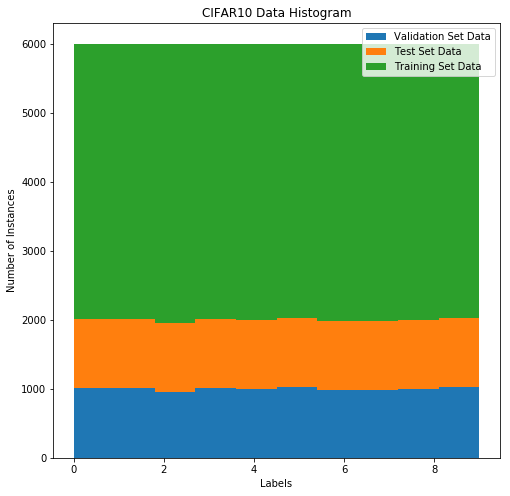

In [10]:
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from keras.datasets import cifar10
import numpy as np

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

train_len = len(X_train)
val_len = np.int(np.ceil(0.2 * train_len))
train_len -= val_len

print (len(X_train))
X_val   = X_train[train_len:]
y_val   = y_train[train_len:]

X_train = X_train[:train_len]
y_train = y_train[:train_len]

print (len(X_val))
print (len(X_train))

# One-hot encode the labels
label_binarizer = LabelBinarizer()
y_one_hot_train = label_binarizer.fit_transform(y_train)
y_one_hot_val   = label_binarizer.fit_transform(y_val)
y_one_hot_test  = label_binarizer.fit_transform(y_test)

# Shuffle the training & validation data
X_train, y_one_hot_train = shuffle(X_train, y_one_hot_train)
X_val, y_one_hot_val = shuffle(X_val, y_one_hot_val)

dataVisualInspection(y_val, y_test, y_train, 10)

# For initial experiement let's use only first 5000 images
# And only the first 1,000 images from the validation set
#X_train = X_train[:5000]
#y_one_hot_train = y_one_hot_train[:5000]
#X_val = X_val[:1000]
#y_one_hot_val = y_one_hot_val[:1000]

In [11]:
# Use a generator to pre-process images for MobileNet
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [12]:
def show_loss_stats(history_object):
    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

In [13]:
from keras.callbacks import TensorBoard as tb
# Train the model
batch_size = 128
epochs = 4

tb_cbk = tb(log_dir="logdir/1")

hist = model.fit_generator(datagen.flow(X_train, y_one_hot_train, batch_size=batch_size), 
                    steps_per_epoch=len(X_train)/batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=val_datagen.flow(X_val, y_one_hot_val, batch_size=batch_size),
                    validation_steps=len(X_val)/batch_size,
                    callbacks=[tb_cbk])
model.save('first_network_cifar10_epoch4_2.h5')

Epoch 1/4
313/312 [==============================] - 53s 169ms/step - loss: 1.2550 - acc: 0.5726 - val_loss: 0.9136 - val_acc: 0.7107
Epoch 2/4
313/312 [==============================] - 50s 161ms/step - loss: 1.0579 - acc: 0.6301 - val_loss: 0.8395 - val_acc: 0.7521
Epoch 3/4
313/312 [==============================] - 51s 163ms/step - loss: 1.0087 - acc: 0.6444 - val_loss: 0.7914 - val_acc: 0.7679
Epoch 4/4
313/312 [==============================] - 51s 164ms/step - loss: 0.9915 - acc: 0.6526 - val_loss: 0.7852 - val_acc: 0.7808


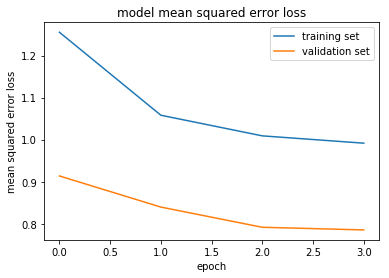

In [14]:
show_loss_stats(hist)

In [15]:
# from keras.models import load_model
# eval_model = load_model('first_network_cifar10_epoch8_2.h5')
# result = eval_model.evaluate(preprocess_input(X_test), y_one_hot_test, verbose=1)

In [16]:
result = model.evaluate(preprocess_input(X_test), y_one_hot_test, verbose=1)
print(model.metrics_names[0], result[0])
print(model.metrics_names[1], result[1]*100)

10000/10000 [==============================] - 12s 1ms/step
loss 0.7987158528327942
acc 77.66


True Label:  automobile
Predicted Label:  automobile


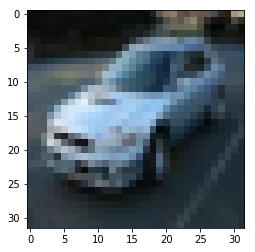

True Label:  frog
Predicted Label:  frog


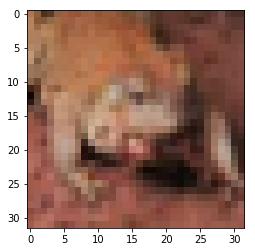

True Label:  bird
Predicted Label:  bird


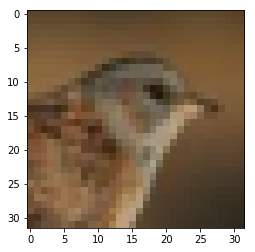

True Label:  ship
Predicted Label:  ship


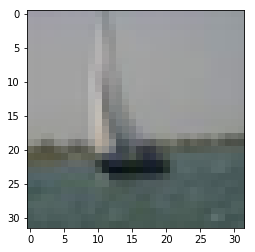

True Label:  truck
Predicted Label:  truck


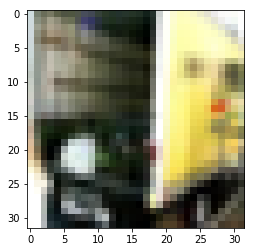

True Label:  horse
Predicted Label:  horse


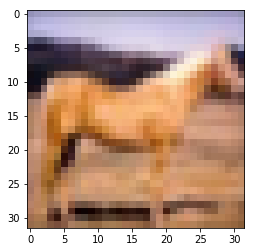

In [17]:
label_dict = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

example_indexes = [240, 5, 980, 55, 654, 700]
for example_index in example_indexes:
    img   = preprocess_input(X_test[example_index])
    label = y_test[example_index]
    plt.imshow(X_test[example_index])
    print ('True Label: ', label_dict[label[0]])
    img = img.reshape(1,32,32,3)
    p = model.predict(img)
    print ('Predicted Label: ', label_dict[np.argmax(p)])
    plt.show()
    #print (p)

Predicted Label:  automobile


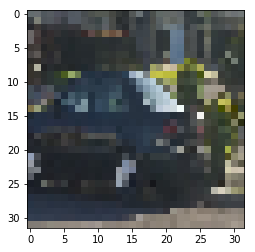

Predicted Label:  bird


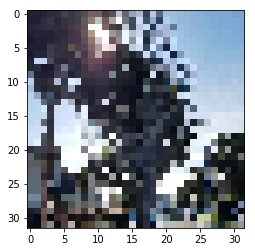

Predicted Label:  airplane


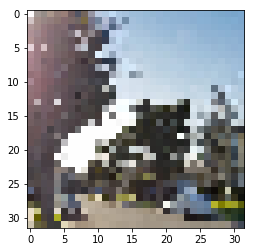

Predicted Label:  truck


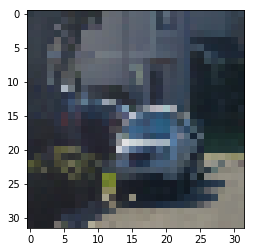

Predicted Label:  truck


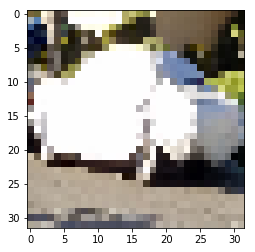

Predicted Label:  horse


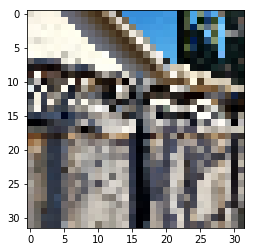

Predicted Label:  frog


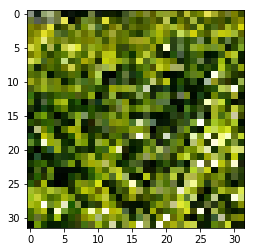

Predicted Label:  truck


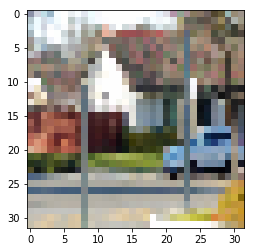

Predicted Label:  ship


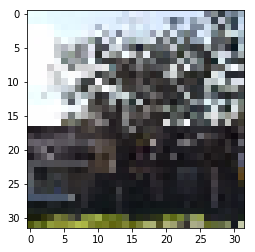

Predicted Label:  truck


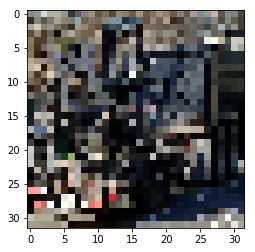

Predicted Label:  truck


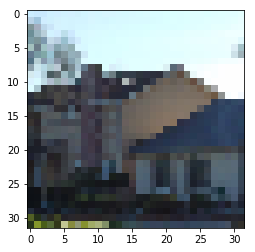

Predicted Label:  airplane


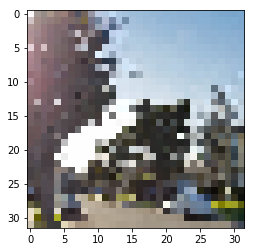

Predicted Label:  automobile


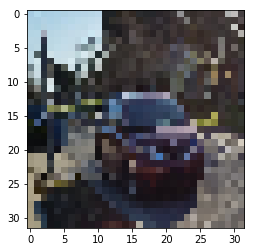

Predicted Label:  truck


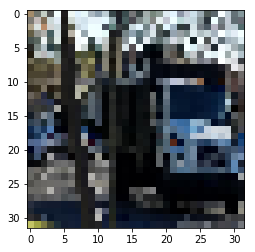

Predicted Label:  truck


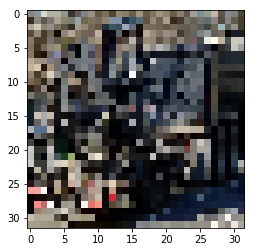

Predicted Label:  dog


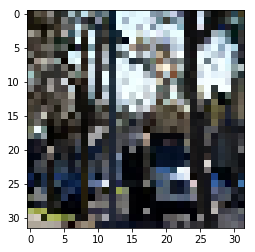

Predicted Label:  truck


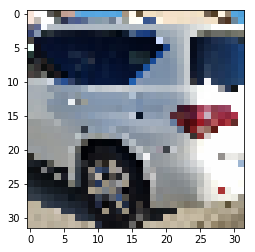

Predicted Label:  automobile


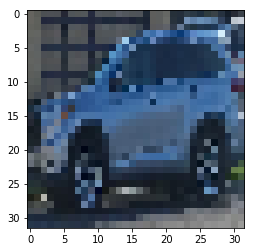

Predicted Label:  truck


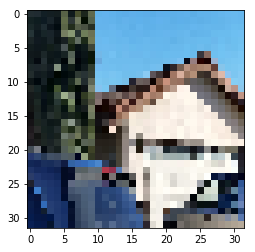

In [18]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import glob

for filename in glob.iglob('Ch3data/*test*.jpg'):
    img      = image.load_img(filename, target_size=(32, 32))
    plt.imshow(img)
    pre_processed_img = image.img_to_array(img)
    pre_processed_img = np.expand_dims(pre_processed_img, axis=0)
    pre_processed_img = preprocess_input(pre_processed_img)
    p = model.predict(pre_processed_img)
    print ('Predicted Label: ', label_dict[np.argmax(p)])
    plt.show()